In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

from data.data_loading import TRANSFORM, create_angle_features
from pose.pose_utils import TESTPATH, CLASS_MAPPINGS_NAMES, LANDMARKS_ANGLES_DICT, LANDMARK_DICT, calc_limb_lengths
from pose.plot import plot_image, plot_3d_keypoints, plot_distribution_with_image
from pose.pose_mediapipe import pose_landmarks_to_list, estimate_poses
from classifier.classify import classify_image
from pose.nearest_neighbor_correction import get_angle_confidence_intervals, create_pose_df, warrior_pose_front_back, \
get_annotated_img, compare_two_figures, select_correct_closest_image, which_leg_front
from gan.test_cLimbGAN import generate_coords_given_limb_lengths
from pose.decision_tree import decision_tree_correct

### Read in Image

In [3]:
# Note that these images are all unseen by the system in training (ie test images) 
# But we have manually classified them as bad images & therefore in need of correction

In [4]:
# TODO Make it so they can select an image or they can read in one at random
# "/0_downwardDog/sddefault.jpg"
# "/0_warrior2/Ashton-warrior-2-wrong.jpg"
PATH = "/0_warrior1/Crescent+Lunge+1.jpg"
EXAMPLE_PATH = str(TESTPATH)+PATH

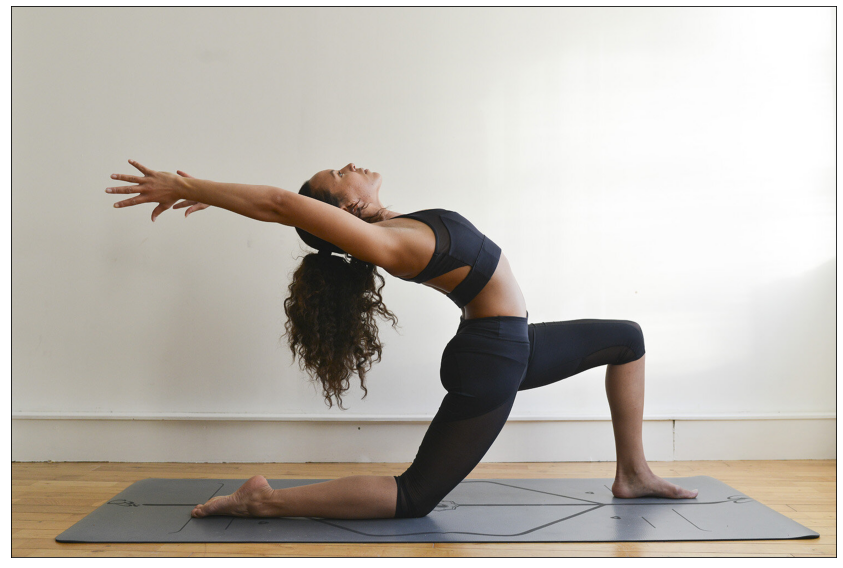

In [5]:
test_image = TRANSFORM(Image.open(EXAMPLE_PATH))
plot_image(test_image, dataloader=True)

### Apply Pose Estimation

In [6]:
test_result, annotated_test_image = estimate_poses(test_image, PATH, skip_image_annotation=False)

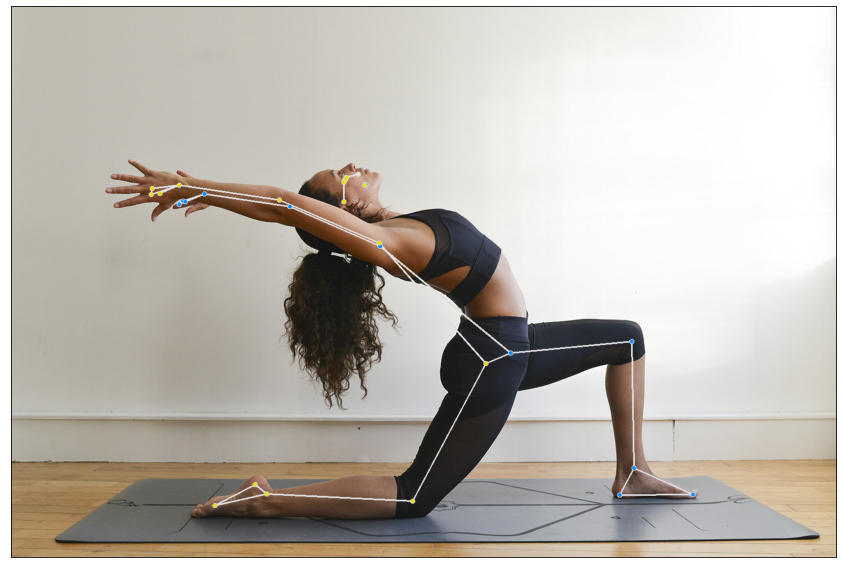

In [7]:
plot_image(annotated_test_image, dataloader=False)

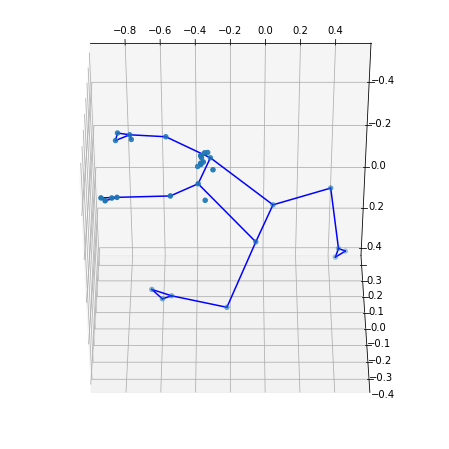

In [8]:
val, _, nump = pose_landmarks_to_list(test_result, 'pose_world_landmarks')

df_test = pd.DataFrame.from_records([val]).rename(LANDMARK_DICT, axis=1)
create_angle_features(df_test)

np_test = np.array([nump])

x = np_test[0].T[0]
y = np_test[0].T[1]
z = np_test[0].T[2]

plot_3d_keypoints(x, y, z, -50, 270)

### Pose Classification

In [9]:
label = classify_image(np_test).item()
print(f"Image Classified as : {CLASS_MAPPINGS_NAMES[label]}")

Image Classified as : W2


In [10]:
df_w1, df_w2, df_dd = create_pose_df()
df_test_handedness = df_test.copy()

if label == 0:
    df = df_dd
    LANDMARKS = LANDMARKS_ANGLES_DICT.keys()
elif label == 1:
    df, LANDMARKS = warrior_pose_front_back(df_w1)
    df_test = which_leg_front(df_test)
elif label == 2:
    df, LANDMARKS = warrior_pose_front_back(df_w2)
    df_test = which_leg_front(df_test)

We calculated that the LEFT foot is the forward foot.


# Pose Correction

### Tree Correction

In [11]:
# create angle features for the pose
create_angle_features(df_test_handedness)
df_test_handedness

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_WRIST_ANGLE,RIGHT_WRIST_ANGLE,LEFT_KNEE_ANGLE,RIGHT_KNEE_ANGLE,LEFT_HIPFLEXOR_ANGLE,RIGHT_HIPFLEXOR_ANGLE,LEFT_ADDUCTOR_ANGLE,RIGHT_ADDUCTOR_ANGLE,LEFT_ANKLE_ANGLE,RIGHT_ANKLE_ANGLE
0,"[-0.3401222825050354, -0.5117447376251221, -0....","[-0.35725754499435425, -0.49470892548561096, -...","[-0.36186033487319946, -0.49326813220977783, -...","[-0.3601243197917938, -0.4947541356086731, -0....","[-0.3610086441040039, -0.5043541193008423, -0....","[-0.35949233174324036, -0.5077748894691467, -0...","[-0.3470084071159363, -0.501644492149353, -0.2...","[-0.38008758425712585, -0.4115836024284363, -0...","[-0.33767470717430115, -0.3617877960205078, -0...","[-0.3241235017776489, -0.48594528436660767, -0...",...,157.348029,143.938663,96.927477,122.027792,132.157438,103.655206,129.828754,124.135003,145.133167,130.075806


In [12]:
decision_tree_correct(df_test_handedness, "W2")

Rules used to predict sample 0:

decision node 0 : (X_test[0, RIGHT_ADDUCTOR_ANGLE] = 124.13500295443708) <= 131.63565063476562)
decision node 1 : (X_test[0, LEFT_ARMPIT_ANGLE] = 148.4236559429733) > 106.19682312011719)
decision node 5 : (X_test[0, LEFT_CHEST_ANGLE] = 72.0429046219728) <= 162.15804290771484)


### The Learned Angle Distribution Correction

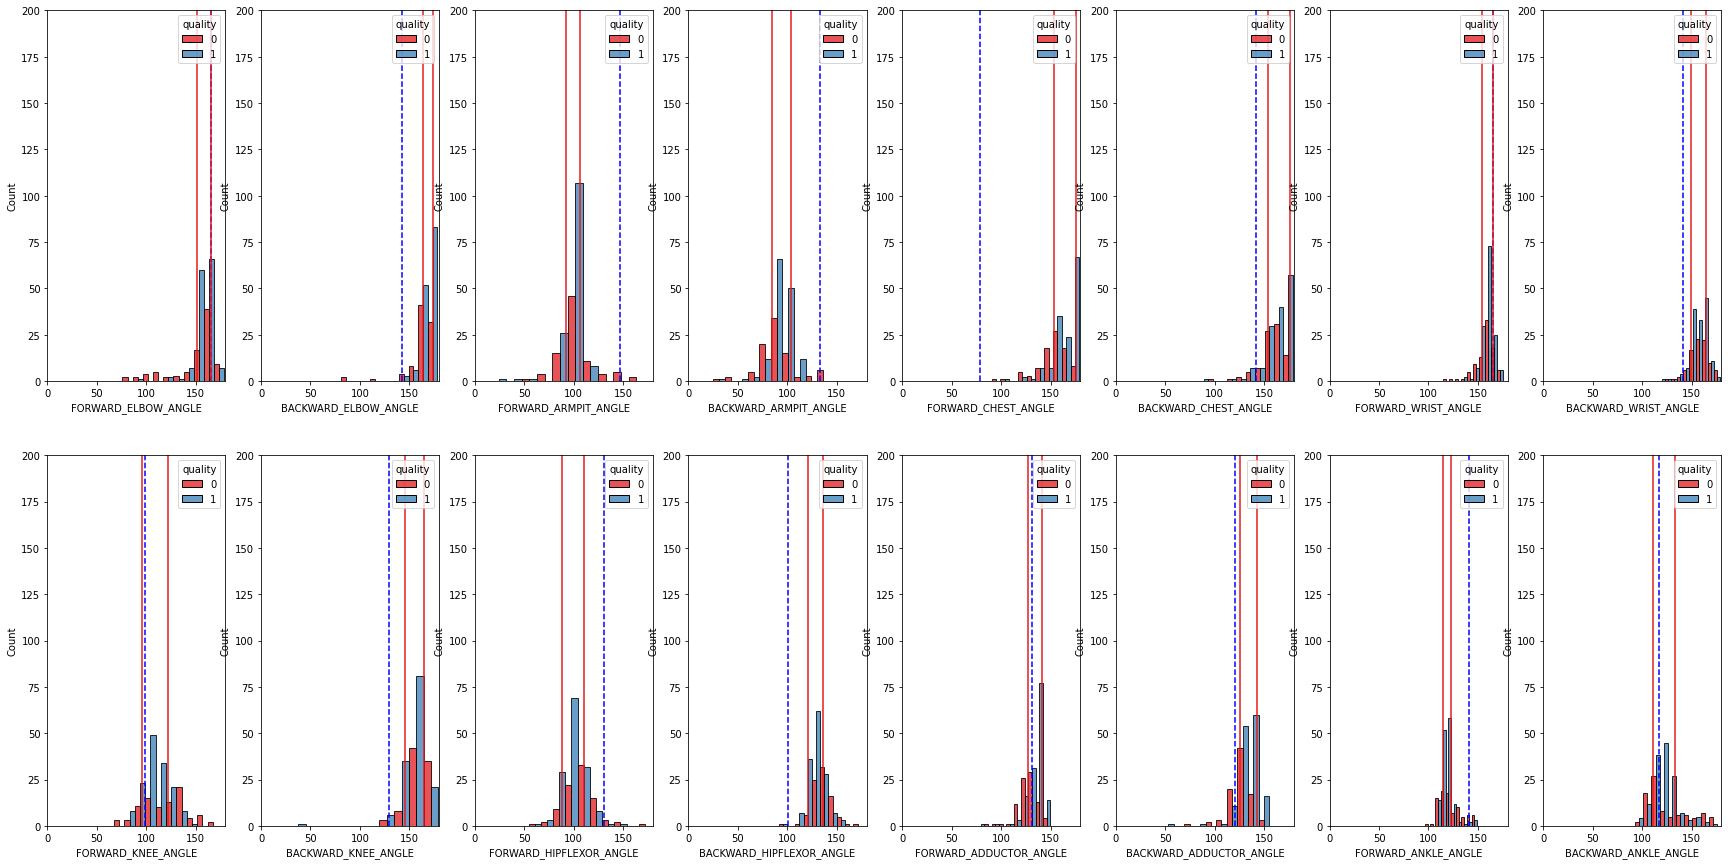

BACKWARD_ELBOW_ANGLE is to small by - 21.3 degrees
FORWARD_ARMPIT_ANGLE is to large by - 41.1 degrees
BACKWARD_ARMPIT_ANGLE is to large by - 29.9 degrees
FORWARD_CHEST_ANGLE is to small by - 74.7 degrees
BACKWARD_CHEST_ANGLE is to small by - 12.1 degrees
FORWARD_WRIST_ANGLE is to large by - 0.0 degrees
BACKWARD_WRIST_ANGLE is to small by - 8.6 degrees
BACKWARD_KNEE_ANGLE is to small by - 16.7 degrees
FORWARD_HIPFLEXOR_ANGLE is to large by - 20.3 degrees
BACKWARD_HIPFLEXOR_ANGLE is to small by - 20.6 degrees
BACKWARD_ADDUCTOR_ANGLE is to small by - 5.0 degrees
FORWARD_ANKLE_ANGLE is to large by - 18.7 degrees


In [11]:
distribution_angles = get_angle_confidence_intervals(df, LANDMARKS, percent = .15)
plot_distribution_with_image(df, df_test, distribution_angles, LANDMARKS)

### The Nearest Neighbour Correction

In [12]:
ground_truth, ground_truth_indx = select_correct_closest_image(np_test, df)
ground_truth_img = get_annotated_img(ground_truth_indx)

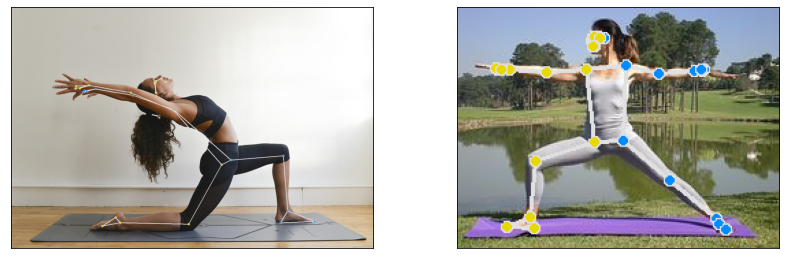

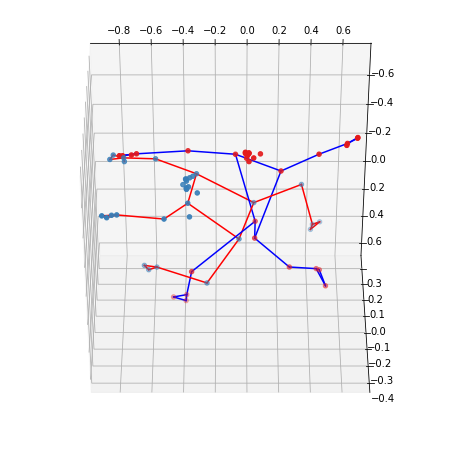

In [13]:
compare_two_figures(np.squeeze(np_test), np.squeeze(ground_truth), annotated_test_image, ground_truth_img, plot=True)

### The Generative GAN Correction

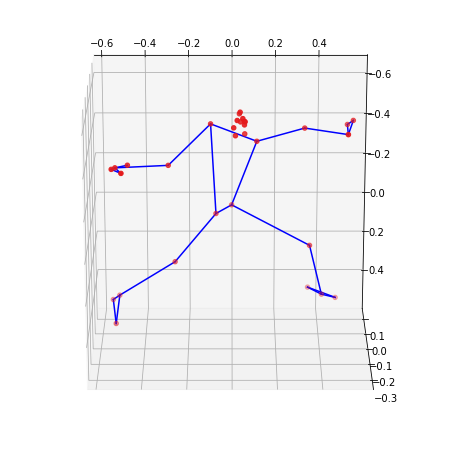

In [14]:
generate_coords_given_limb_lengths(calc_limb_lengths(np.squeeze(np_test, axis=0)), label, version=780, plot=True)